In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

In [2]:
#Tensorflow
import tensorflow as tf
from tensorflow import keras

# Sampler
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Keras
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.applications.resnet50 import ResNet50

# To resize images
from skimage.transform import rescale, resize
import skimage.io
from PIL import Image

# Training and testing with train_test_split
from sklearn.model_selection import train_test_split

# Validation model
from sklearn.metrics import confusion_matrix , classification_report

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
import warnings 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
#Joining the two image zip files together into one dictionary 
base_skin_dir = os.path.join('datasets')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

#Lesion Dictionary 
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Reading the data
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
FilePath = "datasets/hmnist_28_28_RGB.csv"
dataSet = pd.read_csv(FilePath)

In [6]:
Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 

In [7]:
Label.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [8]:
#remove null
skin_df.isnull().sum()
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

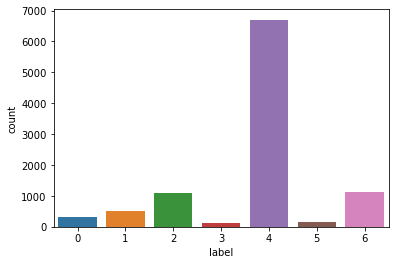

In [9]:
#sns.set_style("darkgrid")
sns.countplot(Label)

<AxesSubplot:>

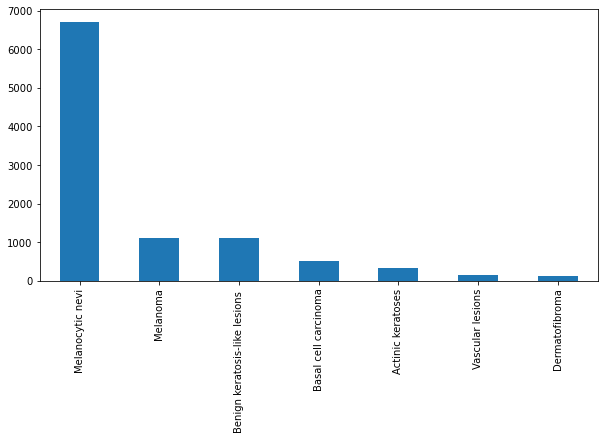

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot:>

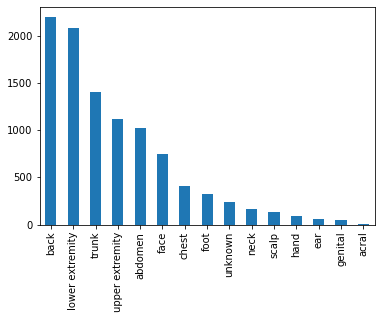

In [11]:
skin_df['localization'].value_counts().plot(kind='bar')

In [12]:
Data = np.array(Data).reshape(-1,28,28,3)

In [13]:
X_train , X_valid , y_train , y_valid = train_test_split(Data , Label , test_size = 0.2 , random_state = 42, stratify=Label)
X_val, X_test, y_val, y_test = train_test_split(X_valid , y_valid , test_size = 0.5, random_state = 101, stratify=y_valid)

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val =  to_categorical(y_val)

In [15]:
print(y_train)
print(y_train.shape)

[[0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]
(8012, 7)


In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            , factor=0.5
                                            , min_lr=0.00001)

In [18]:
def Skin_Lesion_Model():
  input_ = keras.layers.Input(shape = [28,28,3])
  x = keras.layers.Conv2D(32 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(input_)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
  x = keras.layers.MaxPooling2D()(x)

  flatten  = keras.layers.Flatten()(x)
  classifier = keras.layers.Dropout(rate = 0.2)(flatten)

  classifier = keras.layers.Dense(units = 256 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)

  classifier = keras.layers.Dense(units = 128 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier)

  classifier = keras.layers.Dense(units = 64 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 

  classifier = keras.layers.Dense(units = 32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_regularizer=keras.regularizers.L1L2())(classifier)
  classifier = keras.layers.BatchNormalization()(classifier) 

  classifier = keras.layers.Dense(units = 7 , activation='softmax' ,kernel_initializer="glorot_uniform" , name = 'classifier')(classifier)

  return keras.models.Model(inputs = input_  ,outputs =  classifier  )

In [19]:
model = Skin_Lesion_Model()

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0     

In [21]:
model.compile(optimizer='Adam', loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [22]:
base_model = ResNet50(include_top=False, input_shape=(75, 100, 3),pooling = 'avg', weights = 'imagenet')
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/30
63/63 [==============================] - 27s 408ms/step - loss: 1.6625 - accuracy: 0.4848 - val_loss: 2.3329 - val_accuracy: 0.6693
Epoch 2/30
63/63 [==============================] - 26s 414ms/step - loss: 1.0986 - accuracy: 0.6955 - val_loss: 1.1601 - val_accuracy: 0.6743
Epoch 3/30
63/63 [==============================] - 24s 376ms/step - loss: 0.8965 - accuracy: 0.7279 - val_loss: 1.3913 - val_accuracy: 0.6813
Epoch 4/30
63/63 [==============================] - 22s 345ms/step - loss: 0.8111 - accuracy: 0.7364 - val_loss: 0.9533 - val_accuracy: 0.7143
Epoch 5/30
63/63 [==============================] - 23s 370ms/step - loss: 0.7433 - accuracy: 0.7484 - val_loss: 0.8433 - val_accuracy: 0.7193
Epoch 6/30
63/63 [==============================] - 25s 392ms/step - loss: 0.7049 - accuracy: 0.7524 - val_loss: 0.8068 - val_accuracy: 0.7333
Epoch 7/30
63/63 [==============================] - 29s 464ms/step - loss: 0.6466 - accuracy: 0.7736 - val_loss: 0.8019 - val_accuracy: 0.7313

In [23]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 21ms/step - loss: 1.1201 - accuracy: 0.7615


[1.12014639377594, 0.7614770531654358]

(0.0, 1.0)

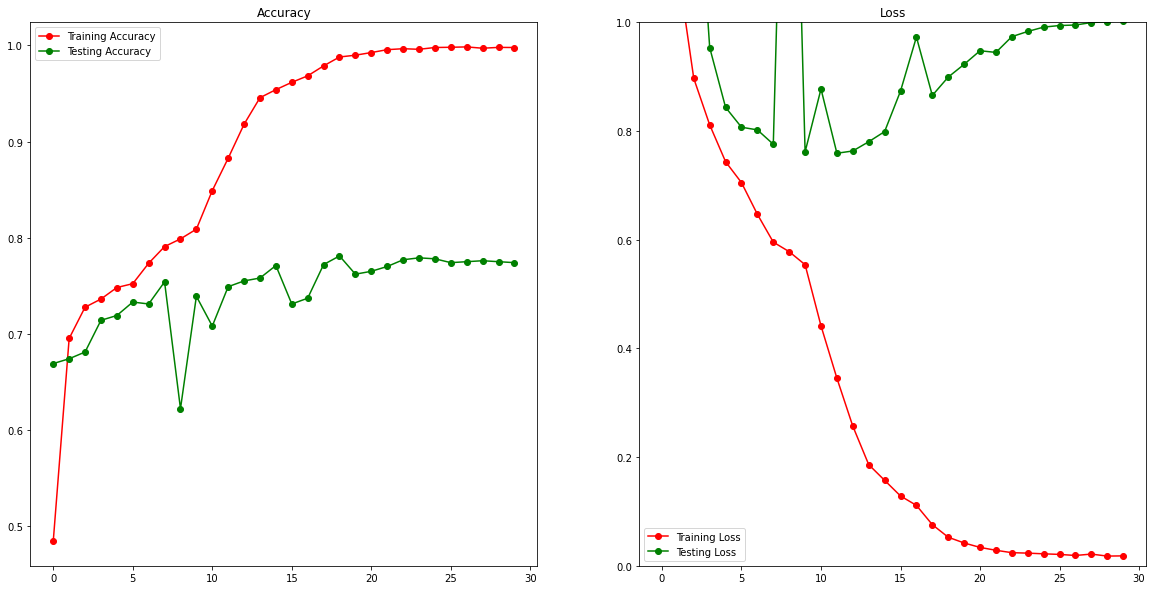

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
ax1.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
ax1.legend()
ax2.set_title('Loss')
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
ax2.legend()
ax1.set_title('Accuracy')
ax2.set_ylim(0, 1)